# DME project - Dimensionality reduction section
This notebook contains the exploratory data analysis performed on the `recipes.csv` data file from Bellosi (2011)

In [2]:
# Display plots inline
%matplotlib inline

# Data libraries

import pandas as pd
import numpy as np
import geopandas as gp

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# Misc libraries
import os
import time
from datetime import date

# Scipy libraries
import scipy.stats as stats   # Imports the entire scipy.stats (all distributions)
from scipy.stats import norm

# sklearn modules
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.manifold import TSNE, Isomap, MDS
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.feature_selection import SelectKBest, VarianceThreshold

# UMAP
import umap.umap_ as umap

# Heatmap 
import plotly.graph_objs as go 
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True) 

# Helper script
import get_recipe as gr

## Data preparation

In [3]:
# Get datasets

recipes_df, cuisines_df = gr.get_data()

## Exploratory data analysis
### Split dataset

In [4]:
train, val = train_test_split(recipes_df, test_size=0.3, random_state=42, stratify=recipes_df['cuisine'])
val, test = train_test_split(val, test_size=(1/3), random_state=42, stratify=val['cuisine'])
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')
print(f'Percentage of train examples: {round(len(train) / len(recipes_df)*100)}%')
print(f'Percentage of validation examples: {round(len(val) / len(recipes_df)*100)}%')
print(f'Percentage of test examples: {round(len(test) / len(recipes_df)*100)}%')

2965 train examples
847 validation examples
424 test examples
Percentage of train examples: 70%
Percentage of validation examples: 20%
Percentage of test examples: 10%


## Dimensionality reduction
### Remove ingredients that only appear once or twice in a recipe

In [5]:
# Get the most popular ingredients in recipes
sums = pd.DataFrame(recipes_df.drop(columns =["cuisine"]).sum(axis = 0), columns = ["counter"])
least_pop_ing = sums.loc[sums["counter"] <= 2].reset_index()["index"].to_list()

In [59]:
print("Ingredients appearing once or twice in recipes:", len(least_pop_ing))

Ingredients appearing once or twice in recipes: 171


In [6]:
# Remove least popular ingredients (appearing only once or twice in recipes)

train_clean = train.copy().drop(columns = least_pop_ing)

### PCA

In [7]:
# get data ready for PCA

pca_df = pd.merge(train_clean, cuisines_df, on = "cuisine", how = "inner")

X = pca_df.drop(columns = ["cuisine", "cuisine_name"])
y = pca_df["cuisine"]
y_name = pca_df["cuisine_name"]

In [8]:
# PCA

pca = PCA(n_components=3)
pca_result = pca.fit_transform(X)
pca_df['pca-one-d'] = pca_result[:,0]
pca_df['pca-two-d'] = pca_result[:,1] 
pca_df['pca-three-d'] = pca_result[:,2]
print(f'Explained variation per principal component: {pca.explained_variance_ratio_}')

Explained variation per principal component: [0.05574191 0.04411006 0.0356519 ]


### UMAP

In [47]:
reducer = umap.UMAP(random_state=26, metric = "jaccard", n_neighbors = )
reducer.fit(X)

C:\Users\Mariel\anaconda3\lib\site-packages\umap\umap_.py:1760: UserWarning:

gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable



UMAP(angular_rp_forest=True, dens_frac=0.0, dens_lambda=0.0, metric='jaccard',
     random_state=26)

In [48]:
embedding = reducer.transform(X)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == reducer.embedding_))
embedding.shape

(2965, 2)

<AxesSubplot:>

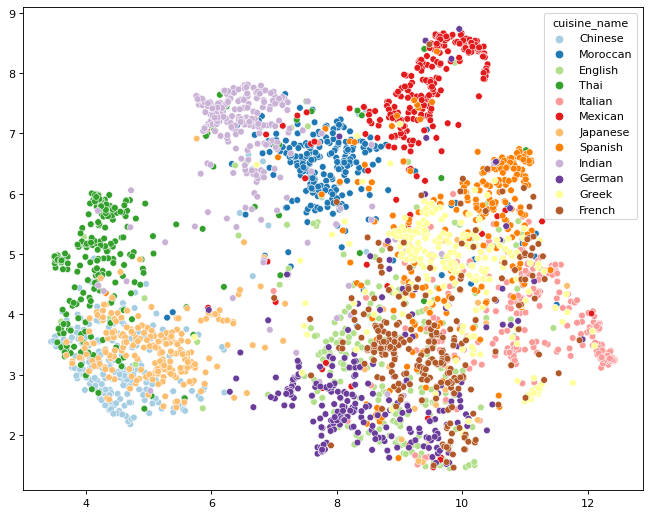

In [51]:
# 2d visualization with seaborn
plt.figure(figsize=(10,8))
sns.scatterplot(
    x=embedding[:, 0], y=embedding[:, 1],
    palette=sns.color_palette("Paired", 12),
    hue = y_name
)

### Metric

In [45]:
metrics= ["jaccard", "cosine", "rogerstanimoto", "dice"]

C:\Users\Mariel\anaconda3\lib\site-packages\umap\umap_.py:1760: UserWarning:

gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable

C:\Users\Mariel\anaconda3\lib\site-packages\umap\umap_.py:1760: UserWarning:

gradient function is not yet implemented for rogerstanimoto distance metric; inverse_transform will be unavailable

C:\Users\Mariel\anaconda3\lib\site-packages\umap\umap_.py:1760: UserWarning:

gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable



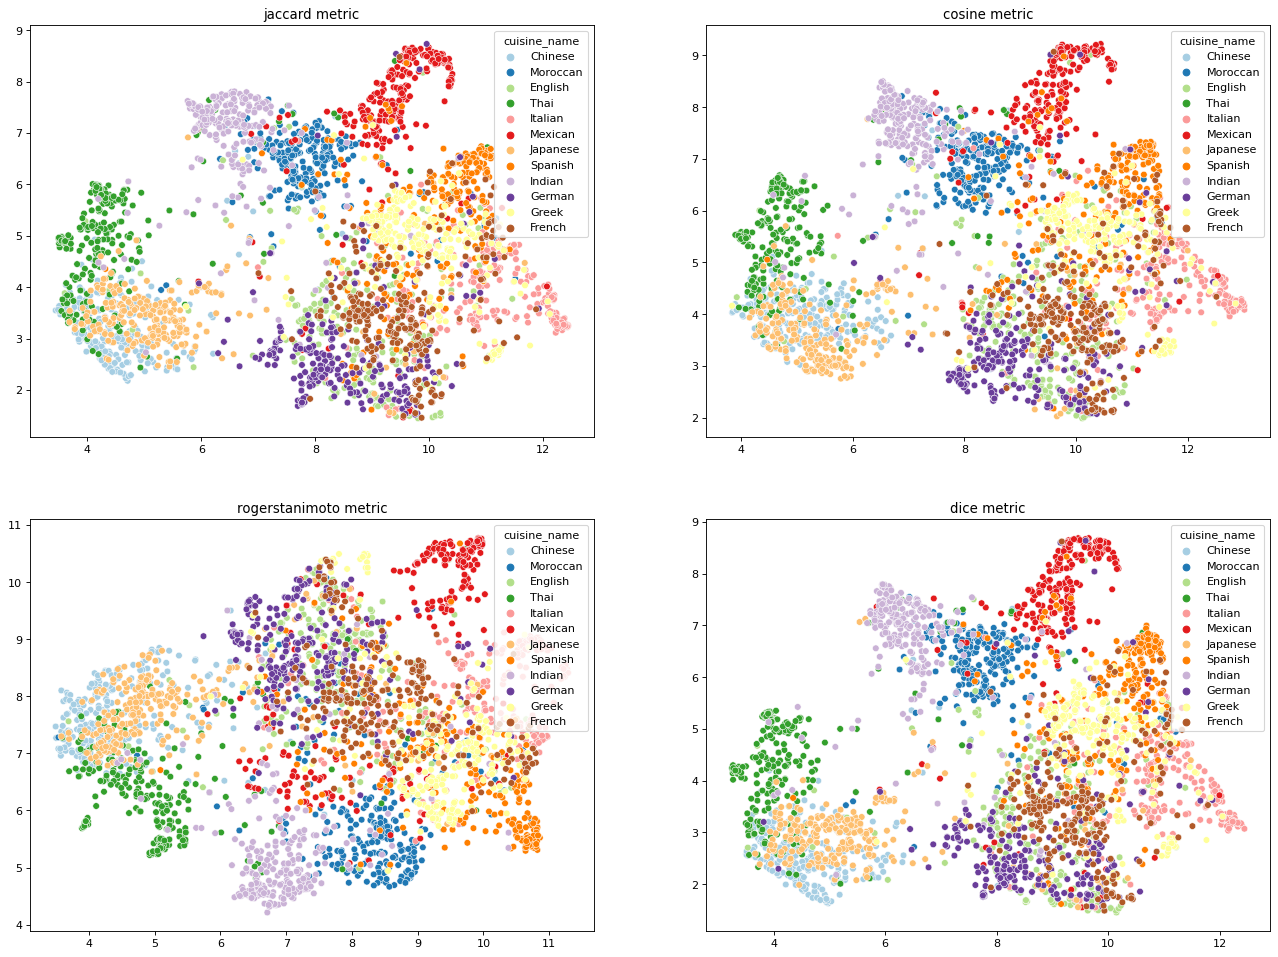

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

for i, param in enumerate(metrics):

    # Create UMAP object
    reducer = umap.UMAP(random_state=26, metric = param)
    reducer.fit(X)
    embedding = reducer.transform(X)

    # 2d visualization with seaborn
    curr_ax = axes[i//2, i%2]
    sns.scatterplot(
        x=embedding[:, 0], y=embedding[:, 1],
        palette=sns.color_palette("Paired", 12),
        hue = y_name, ax = curr_ax
    )

    axes[i//2, i%2].set_title(f'{param} metric')

### N-neighbors

In [61]:
n_neighbours = [14, 15, 16, 17]

C:\Users\Mariel\anaconda3\lib\site-packages\umap\umap_.py:1760: UserWarning:

gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable

C:\Users\Mariel\anaconda3\lib\site-packages\umap\umap_.py:1760: UserWarning:

gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable

C:\Users\Mariel\anaconda3\lib\site-packages\umap\umap_.py:1760: UserWarning:

gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable

C:\Users\Mariel\anaconda3\lib\site-packages\umap\umap_.py:1760: UserWarning:

gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable



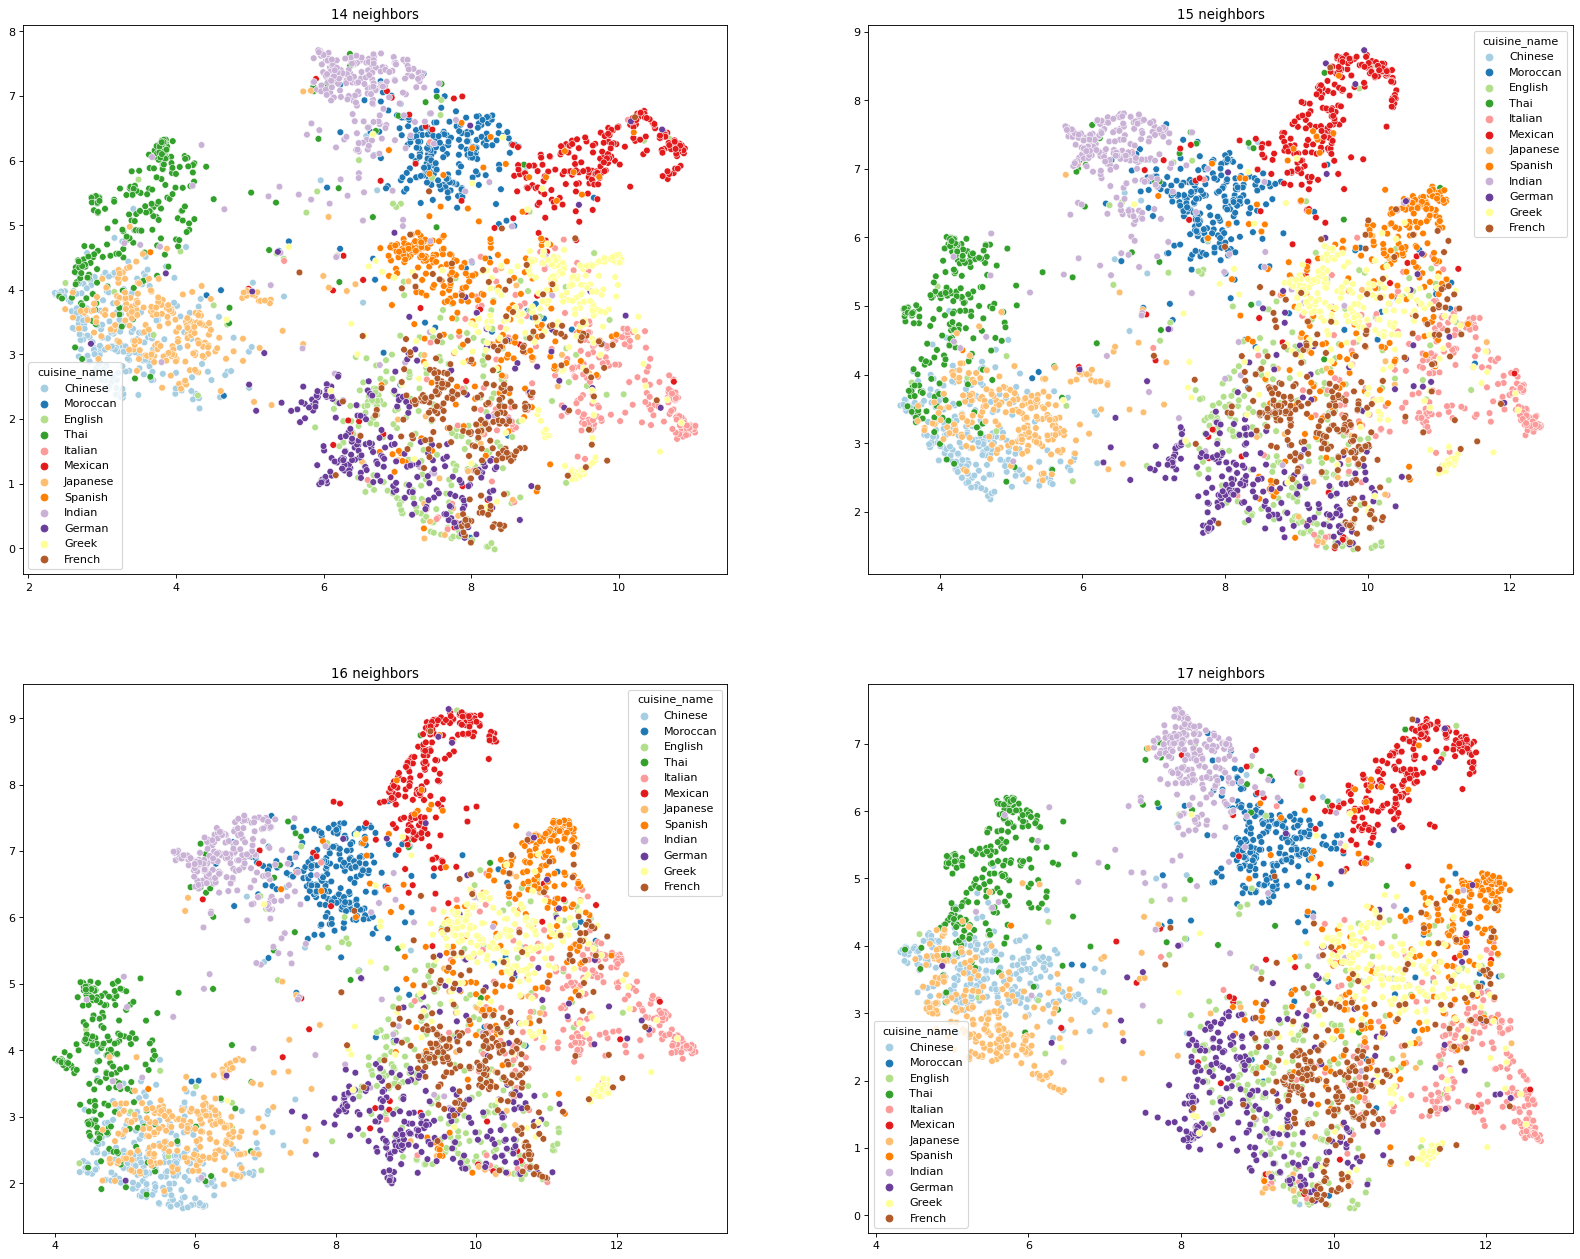

In [63]:
fig, axes = plt.subplots(2, 2, figsize=(25, 20))

for i, param in enumerate(n_neighbours):

    # Create UMAP object
    reducer = umap.UMAP(random_state=26, n_neighbors = param, metric = "jaccard")
    reducer.fit(X)
    embedding = reducer.transform(X)

    # 2d visualization with seaborn
    curr_ax = axes[i//2, i%2]
    sns.scatterplot(
        x=embedding[:, 0], y=embedding[:, 1],
        palette=sns.color_palette("Paired", 12),
        hue = y_name, ax = curr_ax
    )

    axes[i//2, i%2].set_title(f'{param} neighbors')

## Preparing data for TD-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
 

In [ ]:
mallet_columns = [f"ingredient{i}" for i in range(1, 32)] # found that 31 ingredients was the most in any one recipe
mallet_columns.insert(0, "recipe_id")
mallet_columns.insert(1, "cuisine_id")

mallet_df = pd.read_table(malletFile, delimiter=",", header=None, names=mallet_columns)

mallet_df = mallet_df.replace(' ', '_', regex=True) # remove white space and replace with underscore
mallet_df = mallet_df.apply(lambda x: x.astype(str).str.lower()) # convert all strings to lower case 
mallet_df['recipe_id'] = pd.to_numeric(mallet_df['recipe_id']) # converting these columns back to numeric (previous stage converts them to 'object')
mallet_df['cuisine_id'] = pd.to_numeric(mallet_df['cuisine_id'])

mallet_df

In [ ]:
#recipe_cuisine_dict = recipes_df["cuisine"].to_dict()

In [ ]:
# create dictionary for the recipes
recipe_cuisine_dict = {}
recipe_id_dict={}
mallet_dict={}

mallet_under = os.path.join(filePath, "recipes-mallet-under.txt")
with open(mallet_under, 'r') as f:
        for line in f:
            splitLine = line.split(sep =",")
            ingr = [",".join(splitLine[2:]).strip('\n')]
            recipe_id_dict[int(splitLine[0])] = ingr

In [ ]:
mallet_id = recipes_df[["cuisine"]].reset_index()
mallet_id.columns = ["id", "cuisine"]
mallet_id["id"] = mallet_id["id"]+1

In [ ]:
recipes_df.reset_index()

mallet = pd.DataFrame(data=((key, recipe) for key, content in recipe_id_dict.items() for recipe in content), columns =["id", "recipe"])
mallet = pd.merge(mallet, mallet_id, on = "id", how = "inner")
mallet

In [ ]:
# Test for chinese
chinese = mallet[mallet.cuisine == 0]
print(chinese)

In [ ]:
vectorizer = TfidfVectorizer()
doc_vec = vectorizer.fit_transform(chinese["recipe"])

In [ ]:
#doc_vec
not_sure_df = pd.DataFrame(doc_vec.toarray().transpose(), index = vectorizer.get_feature_names())

values_tfidf = not_sure_df.values.flatten()
values_tfidf = values_tfidf[values_tfidf != 0]
values_tfidf = np.sort(-values_tfidf)
len(values_tfidf)

In [ ]:
not_sure_df

In [ ]:
cos_sim = cosine_similarity(X = not_sure_df.T, Y = not_sure_df.T)

In [ ]:
cos_sim.max()

In [ ]:
cos_sim_df = pd.DataFrame(data = cos_sim)
cos_sim_df